In [27]:
import torch
import math
import pyro
from pyro.infer import HMC, MCMC, SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.distributions import LogNormal, Binomial
from torch.distributions import constraints
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scistats
from scipy.special import binom
from collections import defaultdict

In [20]:
# -*- coding: utf-8 -*-

import codecs

def get_basic_phoneme(phoneme):
	if phoneme[-1].isdigit():
		return phoneme[:-1]
	return phoneme

def get_phonemes(phonemes_code):
	return tuple([get_basic_phoneme(phoneme_code) for phoneme_code in phonemes_code.split(';')])

def get_pg_pair(pg_pair_code):
	phonemes_code, grapheme = pg_pair_code.split('>')
	return (get_phonemes(phonemes_code), grapheme)

def get_mapping(mapping_code):
	return tuple([get_pg_pair(pg_pair_code) for pg_pair_code in mapping_code.split('|')])

def read_phonix(input_file_name):
	phonix = []
	with codecs.open(input_file_name, encoding = 'utf-8') as input_file:
		for line in input_file:
			line = line.strip()
			if not line: continue
			word, mapping_code = line.split(' ')
			phonix.append((word, get_mapping(mapping_code)))
	return phonix

def pg_pair_to_str(pg_pair):
	phonemes, grapheme = pg_pair
	return '%s>%s' % (';'.join(phonemes), grapheme)

def mapping_to_str(mapping):
	return '|'.join(pg_pair_to_str(pg_pair) for pg_pair in mapping)

In [21]:
def read_freq_list(freq_file_name):
    wordfreqs = {}
    with open(freq_file_name) as input_file:
        for line in input_file:
            line = line.strip()
            word, freq = line.split(' ')
            freq = float(freq)
            wordfreqs[word] = freq
    return wordfreqs

In [22]:
phonix = read_phonix('../data/phonix.txt')
phonix_dict = dict(phonix)
wordfreqs = read_freq_list('../data/word-freqs.txt')

In [23]:
def normalize(distr):
    denominator = sum(distr.values())
    return {key: float(value) / denominator for key, value in distr.items()}

In [24]:
def get_pg_freqs(wordfreqs, phonix):
    aggregator = defaultdict(float)
    for word, mapping in phonix:
        if word not in wordfreqs: continue
        wordfreq = wordfreqs[word]
        for pg in mapping:
            aggregator[pg_pair_to_str(pg)] += wordfreq
    return normalize(aggregator)

In [28]:
pg_freqs = get_pg_freqs(wordfreqs, phonix)
pgs = sorted(pg_freqs.keys(), key = lambda pg: pg_freqs[pg], reverse=True) # just wanted to sort it to have an intuitive ordering of pg-pairs
ps = np.array([pg_freqs[pg] for pg in pgs])
pg_idx = {pg : i for i, pg in enumerate(pgs)}

In [29]:
observations = [("cat", True), ("dog", True), ("dinosaur", False)]

In [30]:
def word_pgs(word):
    return [pg_pair_to_str(pg) for pg in phonix_dict[word]]

In [31]:
def observed_pgs(observations):
    pgs = set()
    for word, obs in observations:
        pgs.update(word_pgs(word))
    return pgs

In [32]:
#prior specifies our prior belief regarding how much pg-pairs the child could have been exposed to
prior_mu = np.log(500) # means that the median pg-pair exposure in our prior belief is 500
prior_sigma = 0.1 # specifies how spreaded the prior is. For the actual modeling, we want it to be 
                  # quite spreaded. So, the value around 2-3 shall be best. I put it small here to better
                  # show how prior belief can influence our posterior belief.

In [33]:
p_th = 0.01 # probability of our target pg-pair, derived from corpus
n_th_observed = 0 # how much the kid saw this pg-pair
observations = torch.tensor([n_th_observed])

In [34]:
nmax = 10000 # for our simple model, we are going to first do exact posterior calculation. This is very fast
            # with this model, but it will become infeasible with more complex models. We want some reasonable
            # range of possible pg-exposures for this computation. Let's say that it is about 0 and 10000.

In [35]:
# this function computes the discretized lognormal probabilities for a certain range. It uses integral
# over PDF (probability density function) of normal distribution between f(x[i]) and f(x[i+1]), where
# f is the inverse of the transform between normal and lognormal. This integral is
# expressed via CDF (cumulative density function) of the normal distribution
def lognorm_probs(mu, sigma, maxn):
    xs = np.arange(maxn + 1)
    cdfs = np.zeros_like(xs, dtype = float)
    cdfs[xs > 0] = scistats.norm.cdf((np.log(xs[xs > 0]) - mu) / sigma)
    return cdfs[1:] - cdfs[:-1]

In [36]:
prior_ps = lognorm_probs(prior_mu, prior_sigma, nmax)

In [37]:
# this function computes posterior probabilities using the bayes rule. we can do it in this case,
# because we can easily enumerate all hidden states
# prior_probs is the prior probability of total pg number, p is the probability of a pg-pair,
# and obs is the observed number of this pg-pair
def posterior_probs(prior_probs, p, obs):
    observation_probs = np.zeros_like(prior_probs, dtype = float)
    # compute the probability of sampling the observed number of this pg-pair for all possible total pg-numbers:
    observation_probs[obs:] = binom(np.arange(obs, nmax), obs) * np.power((1 - p), np.arange(nmax - obs))
    # applying the Bayes rule: multiply prior probabilities by observation probabilities, then re-normalize:
    posterior_ps = prior_probs * observation_probs
    posterior_ps /= np.sum(posterior_ps)
    return posterior_ps

In [38]:
post_ps = posterior_probs(prior_ps, p_th, n_th_observed)

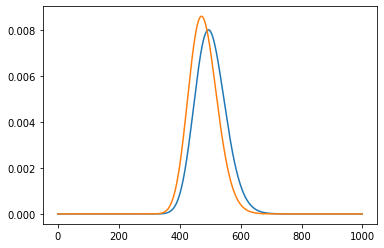

In [9]:
# look at our posterior! It does look pretty much lognormal. Intuitively, that makes a lot of sense:
# lognormal sort of specifies the order of magnitude of the target value; the bigger it is, the less
# precise the measurement becomes (the error is proportional to the value). And it make sense that when
# we estimate the number of pg-pairs the kid was exposed to, we also are going to get more of an order of
# magnitude than exact number.

plt.plot(prior_ps[:1000])
plt.plot(post_ps[:1000])

In [10]:
# this is the model that we would actually want to have. However, I didn't have much luck running it:
# neither with sampling (very slow), nor with variational inference (doesn't converge)
def ideal_model(observations):
    log_n = pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(prior_mu, prior_sigma))
    pyro.sample("n_th_exposed", pyro.distributions.Binomial(total_count = torch.exp(log_n), probs = p_th), obs = observations[0]) 

In [11]:
# this is a model that replaces the binomial with its continuous approximation (from Central Limit Theorem)
# this seems to actually work
def approximate_model(observations):
    log_n = pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(prior_mu, prior_sigma))
    n = torch.exp(log_n)
    pyro.sample("n_th_exposed", pyro.distributions.Normal(loc = n * p_th, scale = math.sqrt(n * p_th * (1 - p_th))), obs = observations[0])

In [12]:
# this is how we would run sampling. Doesn't work! Way too slow!

# pyro.clear_param_store()
# my_kernel = HMC(model)
# my_mcmc = MCMC(my_kernel,
#                num_samples=1000,
#                warmup_steps=100)
# my_mcmc.run(observations)

In [13]:
# This function parametrizes the posterior. Based on considerations described above, I chose the posterior
# number of pg-exposures to come from log-normal. Here, I actually chose to parametrize the log of this value
# (using normal). I think the log parametrization is going to be better, because it naturally accounts for the
# fact that the higher is the mu, the less precision we are going to have.

# I initialize the posterior with the same mu as the prior - it seems to converge quite well
# from that point. But different initializations could be tried.

def guide(observations):
    mu = pyro.param("mu", torch.tensor(prior_mu))
    sigma = pyro.param("sigma", torch.tensor(2), constraint=constraints.positive)
    pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(mu, sigma))

In [14]:
pyro.clear_param_store()

# Define our SVI algorithm. It accepts our model
# our guide, an optimizer, and a loss function
# to maximize
svi = SVI(model=approximate_model,
             guide=guide,
             optim=ClippedAdam({"lr": 0.001}),
             loss=Trace_ELBO())

# Decide on the number of optimization steps to 
# take, and run the optimizer for that
# many steps.

# We sent the parameters into model and guide
# in the .step() function

optimization_steps = 10000
losses, mus, sigmas  = [], [], []
for i in range(10000):
    if 0 == i % 100: print(i)
    losses.append(svi.step(observations))
    mus.append(pyro.param("mu").item())
    sigmas.append(pyro.param("sigma").item())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


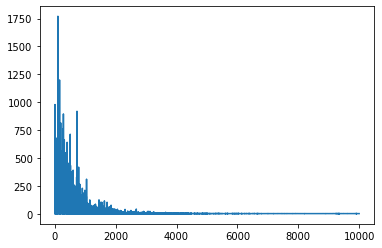

In [15]:
plt.plot(losses)

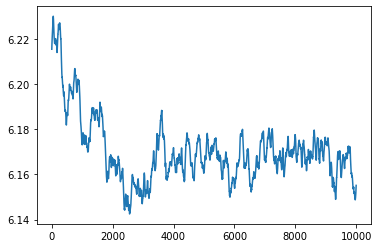

In [16]:
plt.plot(mus)

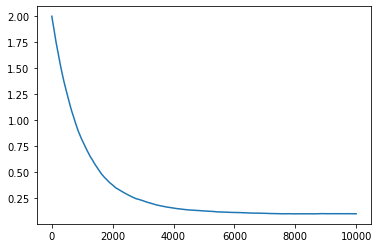

In [17]:
plt.plot(sigmas)

In [18]:
# let's convert our predicted mu and sigma (the last ones in the iteration chain) 
# into the posterior probability distribution!
variational_posterior = lognorm_probs(mus[-1], sigmas[-1], nmax)

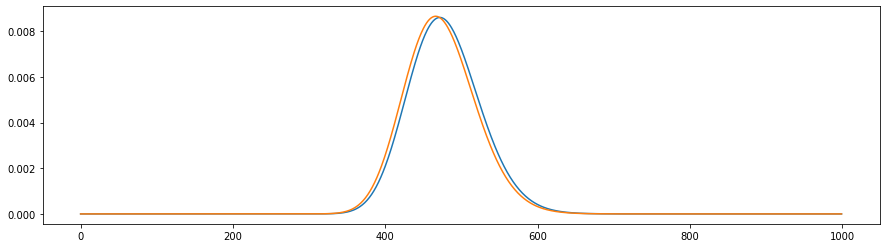

In [19]:
# the match seems to be quite good!
plt.gcf().set_size_inches(15, 4)
plt.plot(post_ps[:1000])
plt.plot(variational_posterior[:1000])